Note: If you are using the Google Colab and want to use tensorflow < 2: you will have to downgrade using this link. https://colab.research.google.com/notebooks/tensorflow_version.ipynb

# Sentiment Analysis on IMDB Movie Review dataset

Sentiment analysis is one of the key areas of research in NLP and Sequence modelling. We will be using LSTMs and Bi-directional LSTMs to predict two classes - positive or negative sentiment.


You will be reading the dataset from here: https://drive.google.com/file/d/127PCwycL0oToSF6l-c2oFuBkacYsmlgK/view?usp=sharing

You can use this blog for understanding: https://towardsdatascience.com/word-embeddings-for-sentiment-analysis-65f42ea5d26e

In [1]:
%tensorflow_version 1.x
import numpy as np 
import pandas as pd 
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Conv1D, Dropout, Bidirectional, Flatten
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split

TensorFlow 1.x selected.


Using TensorFlow backend.


In [0]:
NB_WORDS = 10000
MAX_LEN = 24
ROLL_NUMBER = 20110236
path = '/content/drive/My Drive/DeepLearning/PA6/IMDB.csv'

All the relevant libraries are imported. 
You are free to change as you please. 
Using the GPU backend is recommended as LSTMs are computationally expensive to train.



## Data handling - exploration and cleaning





1.   You are expected to read the dataset into a dataframe.
2.   This is a real world dataset and you will be expected to clean the dataset.

1.   This includes removing trailing spaces and HTML tags.






In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
df = pd.read_csv(path)

### Data Cleaning - write the techniques you employed and the achieved results

In [5]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
import string 
import re
import string
from nltk.corpus import stopwords
stop = stopwords.words('english')

In [0]:
# WRITE CODE HERE
#convert all to lowercase
df['review'] = df['review'].str.lower()
#remove html tag
df['review'] = df['review'].str.replace('<br /><br />', '') 
#remove punctuations
df['review'] = pd.Series([x.translate(str.maketrans('', '', string.punctuation)) for x in df.review]) 
#remove numbers
df['review'] = df['review'].str.replace(r'[0-9]+', '')
#remove stopwords
#df['review'] = df['review'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)])) 

Write about the techniques used to clean:
1. Convert all reviews to lowercase
2. remove html tags
3. removed all punctuations 
4. removed all numbers in the text
5. removed stopwords using nltk stopwords courpus

### Data Exploration



1.   You are required to report the total number of distinct tokens present in the data set.
2.   Find out the minimum and max length of a review.

An integral part of visualization when it comes to textual data is the generating of a word cloud.

1.   
This task is open-ended and you can use any library of your choice. 
NLTK is one such library. 
2.   
Make sure to keep note of stop words.

#### Example:


![alt text](https://getthematic.com/wp-content/uploads/2018/03/Harris-Word-Cloud-e1522406279125.png)




In [0]:
#WRITE CODE HERE
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

stopwords = set(STOPWORDS)
stopwords.update(["film", "movie", "show", "one"])

text = " ".join(review for review in df['review'])

#Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords,background_color="white").generate(text)

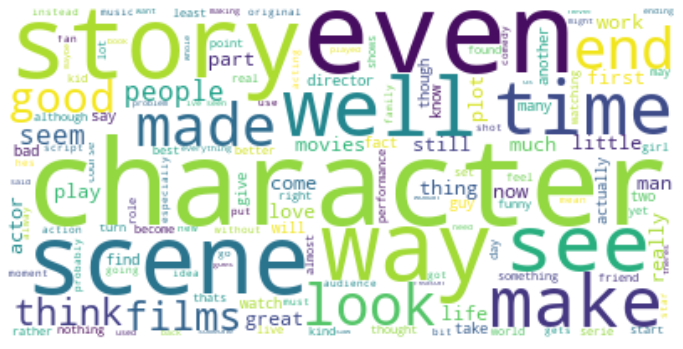

In [19]:
# Display the generated image:
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [20]:
print('Total unique tokens:', len(set(text.split())))
review_lengths = df['review'].apply(lambda x: len(x.split()))
print('Max length of review :', np.max(review_lengths))
print('Min length of review :', np.min(review_lengths))

Total unique tokens: 215737
Max length of review : 2441
Min length of review : 4


### Model processing

You can use a 70:30 train/test split.
The labels are 'positive' and negative, you should assign them integers 0 or 1 for further processing.

In [0]:
from keras.preprocessing.text import text_to_word_sequence
from sklearn.preprocessing import LabelEncoder
from keras.layers import SpatialDropout1D
from keras.utils.np_utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
from keras.utils import plot_model

In [0]:
df['sentiment'] = df['sentiment'].replace('positive',1)
df['sentiment'] = df['sentiment'].replace('negative',0)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(df['review'], df['sentiment'], test_size = 0.30, random_state=37)

### Tokenizer
You will need to use fit a tokenizer over your training and testing data.

What does a tokenizer do?
It creates a dictionary of word to integer mappings. It updates internal vocabulary based on a list of texts. You should read up on the documentation before diving into the code. 

You will also be using the the text_to_sequence function will return integers based on a respective tokenizer.

Make sure you **pad** your sequences to max length using sequence.pad_sequences()




In [94]:
# WRITE CODE HERE
MAX_LEN = 24
NB_WORDS = 10000

tk = Tokenizer(num_words=NB_WORDS,filters='!"#$%&()*+,-./:;<=>?@[\]^_`{"}~\t\n',lower=True, split=" ")
tk.fit_on_texts(X_train)


#defining vocabulary size
VOCAB_SIZE = len(tk.word_index)+1

X_train_seq = tk.texts_to_sequences(X_train)
X_test_seq = tk.texts_to_sequences(X_test)

#padd sequences
X_train_seq_trunc = pad_sequences(X_train_seq, maxlen=MAX_LEN)
X_test_seq_trunc = pad_sequences(X_test_seq, maxlen=MAX_LEN)

print('Vocabbulary size:', VOCAB_SIZE)

Vocabbulary size: 216776


In [0]:
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)

### Embedding layer
You will be importing the embedding layer from Keras.
Embedding layers are common place when handling textual data. 
Word embeddings provide a dense representation of words and their relative meanings.

#### How do they work - via Stack Overflow
Link: https://stats.stackexchange.com/questions/270546/how-does-keras-embedding-layer-work

The output vectors are not computed from the input using any mathematical operation. Instead, each input integer is used as the index to access a table that contains all posible vectors. That is the reason why you need to specify the size of the vocabulary as the first argument (so the table can be initialized).

The most common application of this layer is for text processing. Let's see a simple example. Our training set consists only of two phrases:

Hope to see you soon

Nice to see you again

So we can encode these phrases by assigning each word a unique integer number (by order of appearance in our training dataset for example). Then our phrases could be rewritten as:

[0, 1, 2, 3, 4]

[5, 1, 2, 3, 6]

Now imagine we want to train a network whose first layer is an embeding layer. In this case, we should initialize it as follows:

Embedding(7, 2, input_length=5)

The first argument (7) is the number of distinct words in the training set. The second argument (2) indicates the size of the embedding vectors. The input_length argumet, of course, determines the size of each input sequence.

Once the network has been trained, we can get the weights of the embedding layer, which in this case will be of size (7, 2) and can be thought as the table used to map integers to embedding vectors.


### Model Engineering

You will be required to engineer three types of models from scratch.

1.   Using LSTMs
2.   Bi-directional LSTMs

1.   A model with less than 10,000 parameters - the lower the parameters, higher the score (provided accuracy is good)


For each model:

1.   You will be reporting graphs for validation accuracy and training loss.
2.   What hyper-parameters, loss functions, optimizations, initializations were used. This should be clearly stated in your analysis.

~90 percent and above is the desired accuracy. 

For model 3, CLEARLY report the number of parameters.




In [0]:
def plot(hist):
  # Plot training & validation accuracy values
  plt.plot(hist.history['accuracy'])
  plt.plot(hist.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(hist.history['loss'])
  plt.plot(hist.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

### **1. Simple LSTM**

In [50]:
# CODE HERE
model = Sequential()
model.add(Embedding(input_dim = VOCAB_SIZE, output_dim = 100, input_length=MAX_LEN))
model.add(LSTM(200,dropout = 0.2))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 1420, 100)         21559600  
_________________________________________________________________
lstm_12 (LSTM)               (None, 200)               240800    
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 201       
Total params: 21,800,601
Trainable params: 21,800,601
Non-trainable params: 0
_________________________________________________________________
None


In [52]:
hist = model.fit(X_train_seq_trunc, y_train, validation_data=(X_test_seq_trunc,y_test), epochs = 3,  verbose = 1, batch_size = 32, use_multiprocessing=True)

Train on 35000 samples, validate on 15000 samples
Epoch 1/3
35000/35000 [==============================] - 1978s 57ms/step - loss: 0.3626 - accuracy: 0.8407 - val_loss: 0.2995 - val_accuracy: 0.8773
Epoch 2/3
35000/35000 [==============================] - 1973s 56ms/step - loss: 0.2311 - accuracy: 0.9107 - val_loss: 0.2905 - val_accuracy: 0.8812
Epoch 3/3
35000/35000 [==============================] - 1986s 57ms/step - loss: 0.1773 - accuracy: 0.9334 - val_loss: 0.3232 - val_accuracy: 0.8791


In [55]:
score, acc = model.evaluate(X_test_seq_trunc, y_test,  verbose = 1)
print('Testing accuracy of Model 1 : %.2f' % (acc))

15000/15000 [==============================] - 335s 22ms/step
Testing accuracy of Model 1 : 0.88


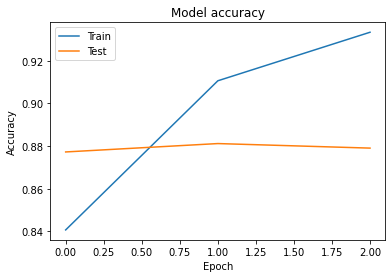

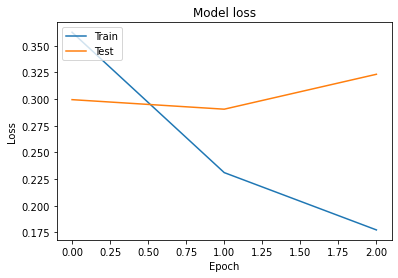

In [56]:
plot(hist)

### **2. Bi-directional LSTM**

In [0]:
model_2 = Sequential()
model_2.add(Embedding(10000, 128, input_length=MAX_LEN))
model_2.add(Bidirectional(LSTM(200, dropout=0.2)))
model_2.add(Dense(1, activation='sigmoid'))
model_2.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

In [31]:
hist2 = model_2.fit(X_train_seq_trunc , y_train, batch_size=32, epochs=10,validation_data=[X_test_seq_trunc, y_test], use_multiprocessing=True)

Train on 35000 samples, validate on 15000 samples
Epoch 1/10
35000/35000 [==============================] - 82s 2ms/step - loss: 0.5130 - accuracy: 0.7449 - val_loss: 0.4702 - val_accuracy: 0.7743
Epoch 2/10
35000/35000 [==============================] - 81s 2ms/step - loss: 0.4004 - accuracy: 0.8178 - val_loss: 0.4800 - val_accuracy: 0.7730
Epoch 3/10
35000/35000 [==============================] - 81s 2ms/step - loss: 0.3145 - accuracy: 0.8623 - val_loss: 0.5288 - val_accuracy: 0.7679
Epoch 4/10
35000/35000 [==============================] - 81s 2ms/step - loss: 0.2278 - accuracy: 0.9042 - val_loss: 0.6513 - val_accuracy: 0.7538
Epoch 5/10
35000/35000 [==============================] - 81s 2ms/step - loss: 0.1531 - accuracy: 0.9373 - val_loss: 0.7970 - val_accuracy: 0.7464
Epoch 6/10
35000/35000 [==============================] - 81s 2ms/step - loss: 0.0987 - accuracy: 0.9630 - val_loss: 0.9943 - val_accuracy: 0.7465
Epoch 7/10
35000/35000 [==============================] - 81s 2ms/st

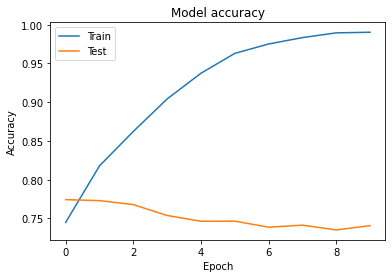

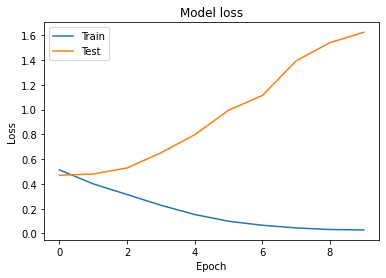

In [34]:
plot(hist2)

### 3. Model with less parameters

In [108]:
model_3 = Sequential()
model_3.add(Embedding(5000,128,input_length=MAX_LEN))
# model_3.add(SpatialDropout1D(0.4))
model_3.add(LSTM(200, dropout=0.2, recurrent_dropout=0.2))
model_3.add(Dense(2,activation='softmax'))
model_3.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
model_3.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_30 (Embedding)     (None, 24, 128)           640000    
_________________________________________________________________
lstm_30 (LSTM)               (None, 200)               263200    
_________________________________________________________________
dense_30 (Dense)             (None, 2)                 402       
Total params: 903,602
Trainable params: 903,602
Non-trainable params: 0
_________________________________________________________________


In [109]:
hist3 = model_3.fit(X_train_seq_trunc , y_train_oh, batch_size=64, epochs=5, validation_data=[X_test_seq_trunc, y_test_oh], use_multiprocessing = True, workers=2)

Train on 35000 samples, validate on 15000 samples
Epoch 1/5
35000/35000 [==============================] - 29s 833us/step - loss: 0.5225 - accuracy: 0.7337 - val_loss: 0.4770 - val_accuracy: 0.7669
Epoch 2/5
35000/35000 [==============================] - 27s 771us/step - loss: 0.4383 - accuracy: 0.7951 - val_loss: 0.4806 - val_accuracy: 0.7655
Epoch 3/5
35000/35000 [==============================] - 27s 772us/step - loss: 0.3981 - accuracy: 0.8204 - val_loss: 0.4933 - val_accuracy: 0.7645
Epoch 4/5
35000/35000 [==============================] - 27s 777us/step - loss: 0.3602 - accuracy: 0.8394 - val_loss: 0.5130 - val_accuracy: 0.7611
Epoch 5/5
35000/35000 [==============================] - 27s 782us/step - loss: 0.3196 - accuracy: 0.8584 - val_loss: 0.5627 - val_accuracy: 0.7605


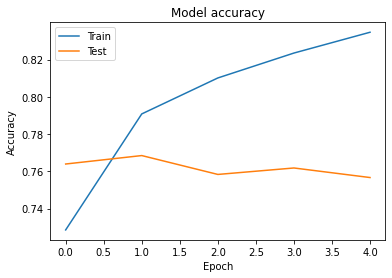

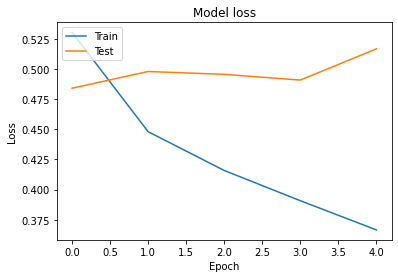

In [65]:
plot(hist3)

### Model Predictions. For your best performing model

Come up with ten sample sentences NOT part of the original data set. 
Use model.predict() to generate predictions and report positive or negative sentiment.

For validation i used movie revies for Extraction movie released recently from rotten tomatoes

In [0]:
def predict_sentiment(model,sentences):
  sentiments = []
  twt = tk.texts_to_sequences(sentences)
  twt = pad_sequences(twt, maxlen=MAX_LEN)
  
  scores = model.predict(twt,verbose = 2)

  for s in scores:
    if np.argmax(s) == 1:
      sentiments.append('positive')
    else:
      sentiments.append('negative')
  return sentiments

In [0]:
sentences = ['The action scenes are great, and some of the camera work and filming techniques are fantastic.',
             'Just a good solid action flick, Hemsworth does a great job, and well directed.',
             'The premise of the movie was supposed to set in Dhaka, a city of 10+ million people in Bangladesh. Unfortunately, they completely missed mark making the set in Dhaka.',
             'You are looking for gun fight action movie ,just go for it.',
             'I dont care how it portrayed Dhaka. It was a great action thriller. Plot is not anything serious or unique, but actions are great really.',
             'How on earth a movie of this level have literally portraying no motive of kidnapping at all. Chris did his best !',
             'Good close quarter combats but a plot would have been nice. Recommended if you are stuck in quarantine and have nothing better to do with your life like me.',
             'Just in short, over hyped movie. Storyline too much poor, if you just exclude Chris from the cast, it doesnt even worth watching',
             'Russo realized that he may not be Thor anymore but he is still Hemsworth.... loved the action, and the long continuous shots hard work paid off too, though the story was a bit drag.... Good star cast.',
             "Extraction is Netflix's best action original of its history!"
             ]

In [0]:
sentiments = predict_sentiment(model,sentences)
for i in range(len(sentences)):
  print(sentiments[i],'--->',sentences[i])

positive ---> The action scenes are great, and some of the camera work and filming techniques are fantastic.
positive ---> Just a good solid action flick, Hemsworth does a great job, and well directed.
negative ---> The premise of the movie was supposed to set in Dhaka, a city of 10+ million people in Bangladesh. Unfortunately, they completely missed mark making the set in Dhaka.
negative ---> You are looking for gun fight action movie ,just go for it.
positive ---> I dont care how it portrayed Dhaka. It was a great action thriller. Plot is not anything serious or unique, but actions are great really.
negative ---> How on earth a movie of this level have literally portraying no motive of kidnapping at all. Chris did his best !
negative ---> Good close quarter combats but a plot would have been nice. Recommended if you are stuck in quarantine and have nothing better to do with your life like me.
negative ---> Just in short, over hyped movie. Storyline too much poor, if you just exclude 